In [1]:
import numpy as np
import pandas as pd
import math as mth
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import time

In [2]:
sandp500 = pd.read_csv ('sandp500/all_stocks_5yr.csv')
sandp500['date'] = pd.to_datetime(sandp500['date'])

#Study only a particular company right now
company = pd.read_csv('sandp500/individual_stocks_5yr/AAPL_data.csv')
company['date'] = pd.to_datetime(company['date'])

In [3]:
#Function that returns specific time-range stockvalues for a particular company
def period(df, initial, final):
    df = df.set_index(['date'])
    return df.loc[initial:final].reset_index()

# (1) AD Analysis

In [4]:
# https://www.investopedia.com/terms/a/accumulationdistribution.asp
# A/D=Previous A/D+CMFV where CMFV = ((c - l) - (h - c))/(h - l)

def AD (p):
 
    for x in all_companies:
        temp = sp500.loc[x]
        c = np.empty((p-1,))
        c[:] = np.NaN
        c = list(c)
        c.extend(temp['close'].iloc[p-1:])
   
        v = temp['volume'].rolling(window = p).sum()
        h = temp['high'].rolling(window = p).max()
        l = temp['low'].rolling(window = p).min()
        
        AD = v * (((c - l) - (h - c))/(h - l))
        output = AD.cumsum()
        sp500.loc[x,'Accum_Distri'] = pd.DataFrame(output)

#p = 14: Time period (in days)
#     initial = company['date'][0]
#     final = initial + pd.Timedelta(p, unit='d')
#     itr = 1 # To start the process for the 1st iteration
#     output = []
#     last_elem = company['date'].iloc[-1]

#     while final <= last_elem:
#         temp = period(company, initial, final) #A pandas frame with only the stocks in the particular time range
    
        
#         if itr == 1:
#             v = temp['volume'].sum()
#             c = temp['close'][len(temp)-1]
#             h = temp['high'].max()
#             l = temp['low'].min()
#             AD = v * (((c - l) - (h - c))/(h - l))
#         else:
#             v = temp['volume'].sum()
#             AD += v * (((c - l) - (h - c))/(h - l))
#             c = temp['close'][len(temp)-1]
#             h = temp['high'].max()
#             l = temp['low'].min()
#             output.append(AD)

#         initial += pd.Timedelta(1, unit='d')
#         final += pd.Timedelta(1, unit='d')
#         itr = 0

# (2) GOPALAKRISHNAN RANGE INDEX (GAPO Index)

In [5]:
# Standard code for working on specific time-range stockvalues for a particular company
def GAPO (p):
#     initial = company['date'][0]
#     final = initial + pd.Timedelta(p, unit='d')
#     output = []
#     last_elem = company['date'].iloc[-1]

#     while final <= last_elem:
#         temp = period(company, initial, final) #A pandas frame with only the stocks in the particular time range
#   initial += pd.Timedelta(1, unit='d')
#         final += pd.Timedelta(1, unit='d')
        
    for x in all_companies:
        temp = sp500.loc[x]
        
        hh = temp['high'].rolling(window = p).max()
        ll = temp['low'].rolling(window = p).min()
        
        GAPO = np.log(hh-ll)/np.log(p)
        sp500.loc[x,'GAPO'] = pd.DataFrame(GAPO)

# (3) LINEAR REGRESSION FORECAST (LRF)

In [6]:
# Standard code for working on specific time-range stockvalues for a particular company
def LRF (company, p):
    initial = company['date'][0]
    final = initial + pd.Timedelta(p, unit='d')
    output = [[],[],[]]
    last_elem = company['date'].iloc[-1]

    while final <= last_elem:
        temp = period(company, initial, final) #A pandas frame with only the stocks in the particular time range
        
        temp['average'] = temp.apply(lambda row: (row.high + row.low)/2. , axis = 1)         
        x = np.array(temp.apply(lambda row: row.date.value/10**9/86400, axis = 1))
        output[0].extend(x)
        output[1].extend(temp['average'])
        
        answer = LinearRegression().fit(x.reshape(-1, 1), np.array(temp['average']).reshape(-1, 1),)
        output[2].extend(answer.coef_[0][0]*x + answer.intercept_[0])       

        initial = final + pd.Timedelta(1, unit='d')
        final = initial + pd.Timedelta(p, unit='d')

    return output

# (4) On Balance Volume (OBV)

In [7]:
# Standard code for working on specific time-range stockvalues for a particular company
def OBV (p):
#     initial = company['date'][0]
#     final = initial + pd.Timedelta(p, unit='d')
#     output = []
#     itr=1
  
#     last_elem = company['date'].iloc[-1]

#     while final <= last_elem:
#         temp = period(company, initial, final) #A pandas frame with only the stocks in the particular time range
    for x in all_companies:   
        temp = sp500.loc[x]
        v = temp['volume'].rolling(window = p).sum()
        c = np.empty((p-1,))
        c[:] = np.NaN
        c = list(c)
        c.extend(temp['close'].iloc[p-1:])
        
        for i in range(p, len(c)):
            if c[i] < c[i-1]:
                v[i] = - v[i]
            if c[i] == c[i-1]:
                v[i] = 0
            
        obv = np.cumsum(v)
        sp500.loc[x,'On_Bal_Vol'] = pd.DataFrame(obv)
#         else:
#             if temp['close'][len(temp)-1] > c:
#                 obv += v
#             elif temp['close'][len(temp)-1] < c:
#                 obv -= v
#             else:
#                 obv = obv
                
#         output.append(obv)

#         initial += pd.Timedelta(1, unit='d')
#         final += pd.Timedelta(1, unit='d')
        
#         c = temp['close'][len(temp)-1]
#         itr = 0

# (5) Relative Strength Index (RSI)

In [8]:
# Standard code for working on specific time-range stockvalues for a particular company
def RSI (p):
    for x in all_companies:
        temp = sp500.loc[x]
        
        difference = temp['close'].diff()
        up, down = difference.copy(), difference.copy()
        up [up < 0] = 0
        down [down > 0] = 0
        rs = up.rolling(window = p).mean() / down.abs().rolling(window = p).mean()
        rsi = 100.0 - (100.0 / (1.0 + rs))
        sp500.loc[x,'RSI'] = pd.DataFrame(rsi)
    
#     initial = company['date'][0]
#     final = initial + pd.Timedelta(p, unit='d')
#     output = []
#     itr = 1
#     rsi = 0
#     loss = []
#     profit = []
#     last_elem = company['date'].iloc[-1]

#     while final <= last_elem:
#         temp = period(company, initial, final) #A pandas frame with only the stocks in the particular time range
        
#         for row in range(1, len(temp)):
#             if temp['close'][row] < temp['close'][row-1]:
#                 loss.append(100*(temp['close'][row-1] - temp['close'][row])/temp['close'][row-1])
#             else:
#                 profit.append(100*(temp['close'][row] - temp['close'][row-1])/temp['close'][row-1])
        
#         if loss == []:
#             loss = [0]
#         if profit == []:
#             profit = [0]
            
#         loss = np.mean(loss)/p
#         profit = np.mean(profit)/p
        
#         if itr == 1:
#             rsi = 100 - (100 / (1+profit/loss) )
#         else:
#             rsi = 100 - (100 / (1 + ((prev_profit)*(p-1) + profit)/((prev_loss)*(p-1) + loss)))
            
#         output.append(rsi)

#         initial += pd.Timedelta(1, unit='d')
#         final += pd.Timedelta(1, unit='d')
#         itr = 0
#         prev_loss = loss
#         loss = []
#         prev_profit = profit
#         profit = []

#     return output

# (6) Weighted Close (WC)

In [9]:
# Note there is no time granularity for WC analysis
def WC(p):        
    for x in all_companies:
        temp = sp500.loc[x]
        output = (temp['high'] + temp['low'] + 2*temp['close'])/4
        sp500.loc[x,'Weighted_Close'] = pd.DataFrame(output)

# (7) Williams %R Formula (WRF)

In [10]:
def WRF (p):
#     initial = company['date'][0]
#     final = initial + pd.Timedelta(p, unit='d')
#     output = []
#     last_elem = company['date'].iloc[-1]
#     while final <= last_elem:
#         temp = period(company, initial, final) #A pandas frame with only the stocks in the particular time range
#         initial += pd.Timedelta(1, unit='d')
#         final += pd.Timedelta(1, unit='d')

    for x in all_companies:
        temp = sp500.loc[x]

        hh = temp['high'].rolling(window = p).max()
        ll = temp['low'].rolling(window = p).min()
        close = np.empty((p-1,))
        close[:] = np.NaN
        close = list(close)
        close.extend(temp['close'].iloc[p-1:])
        
        WR = (hh-close)/(hh-ll)*(-100)
        sp500.loc[x,'Will_R_Form'] = pd.DataFrame(WR)

# (8) Aaron Oscillator (AO)

In [11]:
def AO (p):
    for x in all_companies:
        stocks = sp500.loc[x]
        output = np.empty((p-1,))
        output[:] = np.NaN
        output = list(output)
        first_run = True
        ctr1 = 0
        ctr2 = 0
        hh = 0
        ll = 0
        itr = p

        while itr <= len(stocks): 
            temp = stocks.iloc[itr - p: itr]
            if first_run or ctr1 == 25:
                hh = temp['high'].max()
                ctr1 = p - temp['high'].values.argmax() - 2

            if first_run or ctr2 == 25:
                ll = temp['low'].min()
                ctr2 = p - temp['low'].values.argmin() - 2
                
            if temp['high'].iloc[-1] >= hh:
                ctr1 = 0
                hh = temp['high'].iloc[-1]
            else: 
                ctr1 += 1

            if temp['low'].iloc[-1] <= ll:
                ctr2 = 0
                ll = temp['low'].iloc[-1]
            else: 
                ctr2 += 1
            
            a_up = 100*(p-ctr1)/p
            a_down = 100*(p-ctr2)/p
            a_osc = a_up - a_down   
            output.append(a_osc)
            itr += 1
            first_run = False
        
        sp500.loc[x,'Aaron_Osc'] = pd.DataFrame(output)

# (9) Donchian Width

In [12]:
def DW (p):    
    for x in all_companies:
        temp = sp500.loc[x]

        hh = temp['high'].rolling(window = p).max()
        ll = temp['low'].rolling(window = p).min()

        DW = hh - ll
        sp500.loc[x,'Donchian_Width'] = pd.DataFrame(DW)

# (10) True Range

In [13]:
def TR (p):    
    for x in all_companies:
        temp = sp500.loc[x]
        TR = temp['high'] - temp['low']
        
        sp500.loc[x,'True_Range'] = pd.DataFrame(TR)

# "MAIN FUNCTION"

In [14]:
sp500 = sandp500.copy()
sp500.set_index(['Name','date'], inplace=True)
all_companies = sp500.index.get_level_values(0).unique() # gets the name of all companies

p = 14 # Time period in days

all_features = [AD,WRF,WC,GAPO,OBV,RSI,DW,TR,AO]

for feature in all_features:
    tic = time.perf_counter()
    if feature == AO:
        AO(25)
    else:
        feature(p)
    
    toc = time.perf_counter()
    print("{0} Done!".format(str(feature)))
    print("Execution time: {0} seconds\n".format(toc - tic))

<function AD at 0x10a7db200> Done!
Execution time: 3.4237237200000017 seconds

<function WRF at 0x10a7dbe60> Done!
Execution time: 3.3817877979999977 seconds

<function WC at 0x10c342a70> Done!
Execution time: 2.577587948999998 seconds

<function GAPO at 0x10a7dbc20> Done!
Execution time: 2.8069093180000024 seconds

<function OBV at 0x10a7ceb00> Done!
Execution time: 16.335508621000002 seconds

<function RSI at 0x10a7ce830> Done!
Execution time: 3.7014944499999984 seconds

<function DW at 0x10a7ced40> Done!
Execution time: 2.8943395490000015 seconds

<function TR at 0x1a1f890200> Done!
Execution time: 2.1935507629999975 seconds

<function AO at 0x10a7cea70> Done!
Execution time: 149.073489368 seconds



In [15]:
sp500.to_csv('Akhilesh_Feature_Generation.csv')

In [16]:
sp500.tail(5)

open   high    low  close   volume  Accum_Distri  \
Name date                                                            
ZTS  2018-02-01  76.84  78.27  76.69  77.82  2982259  8.040917e+09   
     2018-02-02  77.53  78.12  76.73  76.78  2595187  8.025405e+09   
     2018-02-05  76.64  76.92  73.18  73.83  2962031  7.990253e+09   
     2018-02-06  72.74  74.56  72.13  73.27  4924323  7.957796e+09   
     2018-02-07  72.70  75.00  72.69  73.86  4534912  7.930930e+09   

                 Will_R_Form  Weighted_Close      GAPO    On_Bal_Vol  \
Name date                                                              
ZTS  2018-02-01   -43.097015         77.6500  0.636198  2.126335e+09   
     2018-02-02   -68.089431         77.1025  0.603742  2.083458e+09   
     2018-02-05   -90.647482         74.4400  0.734634  2.040218e+09   
     2018-02-06   -85.750000         73.3075  0.787949  1.994824e+09   
     2018-02-07   -78.375000         73.8525  0.787949  2.042164e+09   

                       RSI  Donchian_Width  True_Range  Aaron_Osc  
Name date                                                          
ZTS  2018-02-01  64.912281            5.36        1.58       64.0  
     2018-02-02  56.278229            4.92        1.39       64.0  
     2018-02-05  43.835616            6.95        3.74       64.0  
     2018-02-06  36.742424            8.00        2.43       64.0  
     2018-02-07  40.749064            8.00        2.31       64.0

In [17]:
sp500.describe()

,open,high,low,close,volume,Accum_Distri,Will_R_Form,Weighted_Close,GAPO,On_Bal_Vol,RSI,Donchian_Width,True_Range,Aaron_Osc
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05,6.124060e+05,612406.000000,619032.000000,612406.000000,6.124750e+05,611970.000000,612406.000000,619032.000000,606920.000000
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06,4.144867e+09,-44.208231,83.030201,0.575886,1.873778e+09,53.213440,6.618674,1.522214,12.836064
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06,1.048455e+10,30.178567,97.370982,0.300116,3.958429e+09,16.957998,9.468361,2.172623,60.693720
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00,-4.272621e+10,-952.227723,1.637500,-0.803417,-2.674530e+10,0.000000,0.120000,-0.255000,-100.000000
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06,5.930859e+08,-70.703125,40.237669,0.379163,2.749461e+08,41.209925,2.720000,0.610000,-44.000000
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06,1.685734e+09,-40.723982,62.605000,0.561414,8.810542e+08,53.296899,4.400000,0.990000,32.000000
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06,4.052467e+09,-16.581935,94.371256,0.750647,2.084474e+09,65.435012,7.250000,1.669900,68.000000
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08,2.601108e+11,5.660377,2050.275000,2.205836,7.268371e+10,100.000000,337.420000,138.260000,100.000000


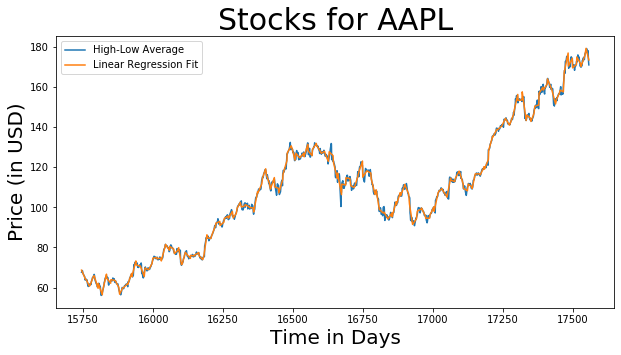

In [18]:
plt.subplots(figsize = (10,5))
p = 14
output = LRF(company, p)
plt.plot(output[0], output[1], label='High-Low Average')
plt.plot(output[0], output[2], label='Linear Regression Fit')
plt.xlabel('Time in Days', size = 20)
plt.ylabel('Price (in USD)', size = 20)
plt.title('Stocks for {0}'.format(company['Name'].iloc[0]), size =30)
plt.legend()
plt.show()